# Seminar 4: SVI

In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 634kB 8.6MB/s 


In [ ]:
import os
from functools import partial
import numpy as np
import math
import pandas as pd
import seaborn as sns
import torch
from torch import nn
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro.distributions import constraints

device = 'cpu'
device

'cpu'

In [ ]:
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Coin example
http://pyro.ai/examples/svi_part_i.html

In [ ]:
# clear all information about previuos parameters - we don't need it anymore
pyro.clear_param_store()

Consider a two-sided coin. We want to determine whether the coin is fair or not, i.e. whether it falls heads or tails with the same frequency. <br>
We have that $P(X = \text{tail}) = p$ and we want to check wether the $p$ is equal to $0.5$.

In [ ]:
# Let's create a data with 10 tails and 20 heads
tails_number = 10
heads_number = 20

data = torch.cat((torch.ones(tails_number), torch.zeros(heads_number)))
data

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We have a prior that the coin is quite fair. As such distribution we get $Beta(10, 10)$ distribution that has mode at 0.5 and simmetric around it:

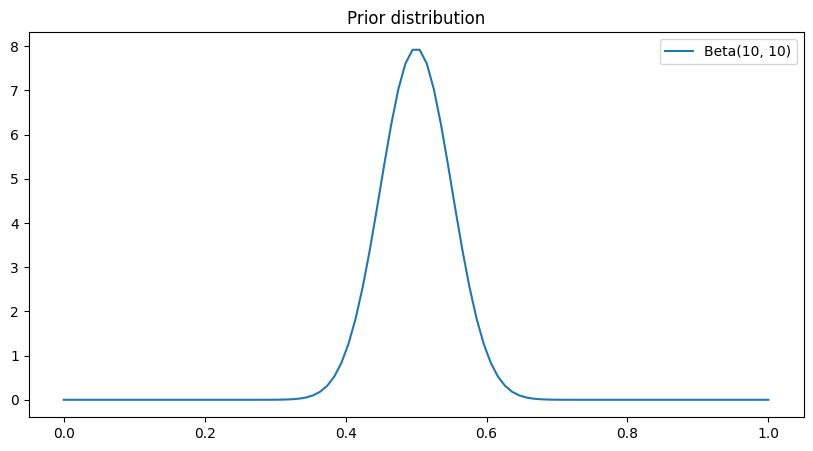

In [ ]:
from scipy import stats

x = np.linspace(0, 1, 100)
y = stats.beta(50, 50).pdf(x)

plt.figure(figsize=(10,5))
plt.plot(x, y, label='Beta(10, 10)')
plt.legend()
plt.title('Prior distribution')
plt.show()

In [ ]:
def model(data): 
    """
    Our model: 
    * sample a parameter 'p' from prior distribution.
    * set our observations to coin distribuion.
    """  
    # define the prior Beta-distribution
    alpha_zero = torch.tensor(10.0).to(data.device)
    beta_zero = torch.tensor(10.0).to(data.device)
    # sample probability 'p' from prior distribuion.
    fairness = pyro.sample("latent_fairness", dist.Beta(alpha_zero, beta_zero))

    # Iterate over our observations
    for i in range(len(data)):
        # Define how we observe our random variable (coin)
        pyro.sample("obs_{}".format(i), dist.Bernoulli(fairness), obs=data[i])

In [ ]:
def guide(data):
    # we setup the distribuion family
    # initial values we setup from our data.
    alpha_q = pyro.param("alpha_q", data.sum(),
                        constraint=constraints.positive)
    beta_q = pyro.param("beta_q", len(data) - data.sum(),
                      constraint=constraints.positive)
    # As posterior we get Beta(alpha_q, beta_q) distribution
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [ ]:
# setup the optimizer + scheduler
adam_parameters = {"lr": 0.1, "betas": (0.90, 0.999)}

optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': adam_parameters, 'gamma': 0.998})

# setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

step_number = 2000

alphas = []
betas = []

data = data.to(device)

for j in range(step_number):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    scheduler.step()
    alphas.append(pyro.param("alpha_q").item())
    betas.append(pyro.param("beta_q").item())
    if j % 100 == 0:
        print("[iteration {:} / {:}] loss: {:.4}, {:.2f}".format(j + 1, step_number, loss, alphas[-1]))

[iteration 1 / 2000] loss: 19.33, 9.05
[iteration 101 / 2000] loss: 19.94, 12.51
[iteration 201 / 2000] loss: 20.07, 17.57
[iteration 301 / 2000] loss: 20.23, 18.42
[iteration 401 / 2000] loss: 20.14, 19.00
[iteration 501 / 2000] loss: 20.21, 18.64
[iteration 601 / 2000] loss: 20.18, 19.66
[iteration 701 / 2000] loss: 20.34, 19.47
[iteration 801 / 2000] loss: 20.24, 19.39
[iteration 901 / 2000] loss: 21.33, 18.42
[iteration 1001 / 2000] loss: 20.03, 20.72
[iteration 1101 / 2000] loss: 20.28, 20.27
[iteration 1201 / 2000] loss: 20.48, 19.70
[iteration 1301 / 2000] loss: 20.35, 20.57
[iteration 1401 / 2000] loss: 20.23, 19.63
[iteration 1501 / 2000] loss: 20.25, 19.53
[iteration 1601 / 2000] loss: 20.08, 18.68
[iteration 1701 / 2000] loss: 20.41, 19.91
[iteration 1801 / 2000] loss: 20.24, 19.48
[iteration 1901 / 2000] loss: 20.21, 19.58


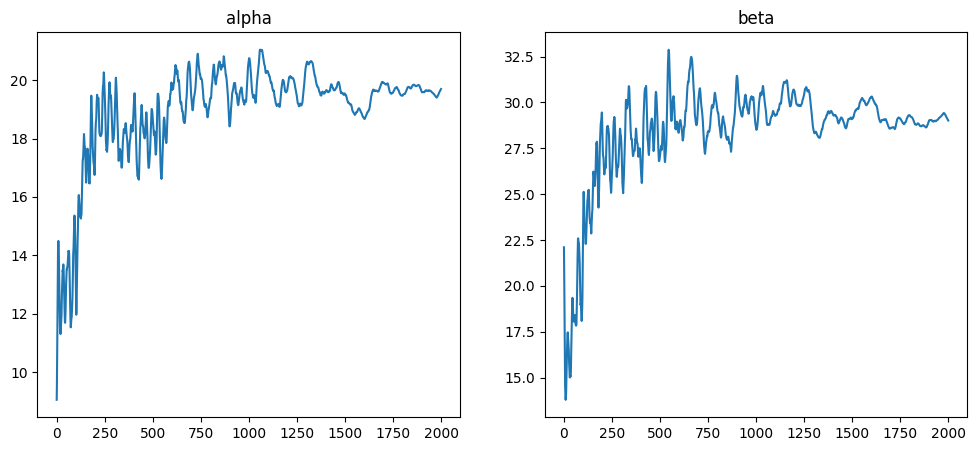

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(alphas)
ax[0].set_title('alpha')

ax[1].plot(betas)
ax[1].set_title('beta')

plt.show()

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

alpha_q tensor(19.6952, grad_fn=<AddBackward0>)
beta_q tensor(29.0154, grad_fn=<AddBackward0>)


In [ ]:
# Get our posterior parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

To compute mean and std of our posterior distribution we use that our posterior is $Beta(\alpha, \beta)$:

$$
E[X] = \frac{\alpha}{\alpha+\beta},\;\;\; Var[X] = \frac{\alpha\beta}{(\alpha+\beta)^2(1+\alpha+\beta)}
$$

In [ ]:
# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
inferred_std = math.sqrt(alpha_q * beta_q / (alpha_q + beta_q)**2 / (1.0 + alpha_q + beta_q))

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.404 +- 0.070


And the truth mean and std are 0.4 +- 0.069. Our results are very close!

In [ ]:
data = torch.tensor([60.3056, 54.1595, 65.3077, 46.0886, 61.0433, 34.0259, 36.2355, 56.7801,
        53.0407, 33.0134])
data.mean()

tensor(50.0000)

In [ ]:
def model(data): 
    """
    Our model: 
    * sample a parameter 'p' from prior distribution.
    * set our observations to coin distribuion.
    """  
    # define the prior Beta-distribution
    a0 = torch.tensor(90.0).to(data.device)
    s = torch.tensor(19.0).to(data.device)
    # sample probability 'p' from prior distribuion.
    a = pyro.sample("a", dist.Normal(a0, s**0.5))

    # Iterate over our observations
    for i in range(len(data)):
        # Define how we observe our random variable (coin)
        pyro.sample("obs_{}".format(i), dist.Normal(a, 10), obs=data[i])

In [ ]:
def guide(data):
    # we setup the distribuion family
    # initial values we setup from our data.
    a = pyro.param("a_q", data.mean())
    s = pyro.param("s_q", data.std(), constraint=constraints.positive)
    # As posterior we get Beta(alpha_q, beta_q) distribution
    pyro.sample("a", dist.Normal(a, s**0.5))

In [ ]:
# setup the optimizer + scheduler
adam_parameters = {"lr": 0.01, "betas": (0.90, 0.999)}

optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': adam_parameters, 'gamma': 1.0})

# setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=Trace_ELBO())

pyro.clear_param_store()
pyro.set_rng_seed(0)

step_number = 5000

alphas = []
betas = []

data = data.to(device)

for j in range(step_number):
    # calculate the loss and take a gradient step
    loss = svi.step(data)
    scheduler.step()
    alphas.append(pyro.param("a_q").item())
    betas.append(pyro.param("s_q").item())
    if j % 100 == 0:
        print("[iteration {:} / {:}] loss: {:.4},| {:.2f}, {:.2f}".format(j + 1, step_number, loss, alphas[-1], betas[-1]))

[iteration 1 / 5000] loss: 70.74,| 50.01, 12.06
[iteration 101 / 5000] loss: 71.08,| 50.95, 10.60
[iteration 201 / 5000] loss: 80.04,| 51.87, 9.59
[iteration 301 / 5000] loss: 78.77,| 52.74, 9.69
[iteration 401 / 5000] loss: 73.98,| 53.59, 9.18
[iteration 501 / 5000] loss: 79.75,| 54.41, 8.42
[iteration 601 / 5000] loss: 74.05,| 55.22, 7.14
[iteration 701 / 5000] loss: 73.32,| 55.96, 7.11
[iteration 801 / 5000] loss: 69.42,| 56.65, 7.11
[iteration 901 / 5000] loss: 70.93,| 57.29, 7.25
[iteration 1001 / 5000] loss: 68.69,| 57.92, 7.26
[iteration 1101 / 5000] loss: 67.77,| 58.54, 6.86
[iteration 1201 / 5000] loss: 66.72,| 59.10, 7.15
[iteration 1301 / 5000] loss: 66.6,| 59.61, 7.20
[iteration 1401 / 5000] loss: 67.52,| 60.10, 7.29
[iteration 1501 / 5000] loss: 66.74,| 60.52, 7.56
[iteration 1601 / 5000] loss: 67.47,| 60.92, 8.00
[iteration 1701 / 5000] loss: 68.79,| 61.31, 8.12
[iteration 1801 / 5000] loss: 66.64,| 61.70, 6.98
[iteration 1901 / 5000] loss: 66.14,| 61.98, 6.74
[iteration 

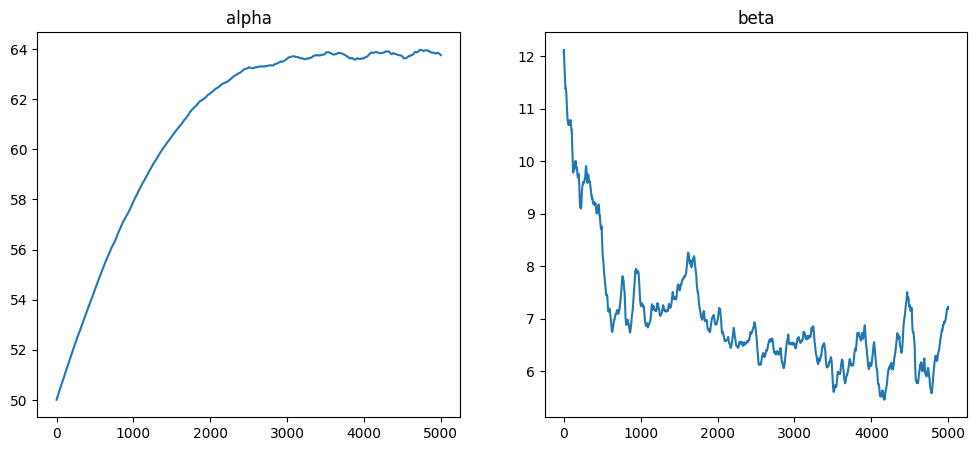

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(alphas)
ax[0].set_title('alpha')

ax[1].plot(betas)
ax[1].set_title('beta')

plt.show()

# VAE: PyTorch vs Pyro

Now we will try to compare PyTroch and Pyro implemeantations of Variational AutoEncoder (VAE).

In [ ]:
import torch
from torch import nn
from torch.functional import F
import torchvision
from torchvision import transforms

pyro.distributions.enable_validation(False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

We condsider MNIST dataset.

In [ ]:
train_set = torchvision.datasets.MNIST(root='./', train=True, transform=transforms.ToTensor(),
                  download=True)
test_set = torchvision.datasets.MNIST(root='./', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=128, shuffle=False)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's construct our encoder $q(z|x)$ and decoder $p(x|z)$:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc = nn.Linear(28*28, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim)
        self.fc_sigma = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 28*28)
        # then compute the hidden units
        hidden = F.relu(self.fc(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_mu = self.fc_mu(hidden)
        z_sigma = F.softplus(self.fc_sigma(hidden))
        return z_mu, z_sigma

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc = nn.Linear(z_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, 784)

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = F.relu(self.fc(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        x_mu = torch.sigmoid(self.fc_mu(hidden))
        return x_mu

We consider latent prior distribution $q(z)\sim\mathcal N(0,I)$.

To pass the gradient through random varibales we use reparametrization trick.

## Task 1
Write a reparametrization trick to pass gradient throught $U(a,b)$ distribution. Name it $u$ and check it.

In [ ]:
a = torch.tensor(10., requires_grad=True)
b = torch.tensor(-5., requires_grad=True)

In [ ]:
# Your solution is here
u = torch.distributions.Uniform(0,1).sample() 
u = u * (b - a) + a

u.backward()
a.grad, b.grad

(tensor(0.2321), tensor(0.7679))

In [ ]:
# variant 1
u = torch.distributions.Uniform(0,1).sample() 
u1 = u * (b - a) + a

u1.backward()
a.grad, b.grad

(tensor(0.7929), tensor(1.2071))

In [ ]:
# variant 2
u2 = torch.distributions.Uniform(a,b).rsample() 

u2.backward()
a.grad, b.grad

(tensor(1.7471), tensor(1.2529))

### End of the task 1

Now we are back to our VAE. Let's define it in some easy way.

In [ ]:
class VAE_torch(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        self.z_dim = z_dim

    # define a helper function for reconstructing images
    def forward(self, x, n_samples=1):
        # encode image x
        z_mu, z_sigma = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_mu, z_sigma).rsample([n_samples])
        z = z.view(-1, *z_mu.shape[1:])
        # decode the image (note we don't sample in image space)
        img_mu = self.decoder(z)
        img_mu = img_mu.view(-1, 28*28)
        
        return (z_mu, z_sigma), img_mu

To optimize our VAE we optimize the ELBO:

$$
\text{ELBO} = \underbrace{E_{q(z|x)}\log p(x|z)}_\text{LogLikelihood} - KL(q(z|x)\|q(z)) \to \max
$$

Since MNIST image consinsts only 0/1 values we assume that $p(x|z)$ has Bernoulli distribution and therefore we can estimate LogLikelihood as follows:

$$
x_1\sim p(x|z)
$$

$$
\widehat{\text{LL}} = x\cdot \log(x_1) + (1-x)\cdot \log(1-x_1)
$$

However, with such estimation we get noisy gradients. One of the solutions is to get $m$ samples and average it.

$$
x_1,\dots,x_m \sim p(x|z)
$$
$$
\widehat{\text{LL}} = \frac{1}{m}\sum_{i=1}^m x\cdot \log(x_i) + (1-x)\cdot \log(1-x_i)
$$

We will obtain less noisy gradients but the training procedure will take more time.<br>

Now, we define our LL loss and KL divergence. We assume that posterior is $\mathcal N (z_{\mu}, \text{diag}(z_\sigma))$.

In [ ]:
def LogLoss(y_pred, y_true):
    n_samples = y_pred.shape[0] // y_true.shape[0]
    y_true = y_true.repeat(n_samples, 1)
    # logloss
    L = - (y_true * torch.log(y_pred + 1e-16) + (1 - y_true) * torch.log(1 - y_pred + 1e-16))
    return L.sum() / n_samples

def KLLoss(z_mu, z_sigma, prior):
    q = torch.distributions.Normal(z_mu, z_sigma)
    return torch.distributions.kl_divergence(q, prior).sum()

Then we define train and evaluation procedure

In [ ]:
def train(model, optimizer, train_loader, n_samples=1):
    elbo = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        (z_mu, z_sigma), x_mu = vae(x, n_samples=n_samples)
        loss = LogLoss(x_mu, x.view(-1, 28*28)) + KLLoss(z_mu, z_sigma, prior)
        loss.backward()
        optimizer.step()
        
        elbo += loss.item()
        
    return elbo / len(train_loader.dataset)


def evaluate(model, test_loader):
    elbo = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            (z_mu, z_sigma), x_mu = vae(x, n_samples=1)
            loss = LogLoss(x_mu, x.view(-1, 28*28)) + KLLoss(z_mu, z_sigma, prior)
            
            elbo += loss.item()
            
    return elbo / len(test_loader.dataset)

Finally, we train and validate our VAE. Now we optimize ELBO without sampling latent variable several times.

In [ ]:
torch.manual_seed(42)

N_SAMPLES = 1
NUM_EPOCHS = 21
TEST_FREQUENCY = 5

vae = VAE_torch().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

prior = torch.distributions.Normal(torch.tensor(0.).to(device),
                                   torch.tensor(1.).to(device))
train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    elbo = train(vae, optimizer, train_loader, n_samples=N_SAMPLES)
    train_elbo.append(-elbo)
    print("[epoch %03d] average training loss: %.4f" % (epoch, train_elbo[-1]))

    if epoch % TEST_FREQUENCY != 0:
        continue
        
    elbo = evaluate(vae, test_loader)
    test_elbo.append(-elbo)
    print("----------> average test loss: %.4f" % (test_elbo[-1]))

[epoch 000] average training loss: -169.3769
----------> average test loss: -133.7218
[epoch 001] average training loss: -126.2055
[epoch 002] average training loss: -116.9060
[epoch 003] average training loss: -112.9208
[epoch 004] average training loss: -110.6255
[epoch 005] average training loss: -109.2087
----------> average test loss: -107.9138
[epoch 006] average training loss: -108.1614
[epoch 007] average training loss: -107.3593
[epoch 008] average training loss: -106.7752
[epoch 009] average training loss: -106.2676
[epoch 010] average training loss: -105.8731
----------> average test loss: -105.4833
[epoch 011] average training loss: -105.5521
[epoch 012] average training loss: -105.2478
[epoch 013] average training loss: -105.0440
[epoch 014] average training loss: -104.8276
[epoch 015] average training loss: -104.5901
----------> average test loss: -104.1220
[epoch 016] average training loss: -104.4075
[epoch 017] average training loss: -104.2363
[epoch 018] average traini

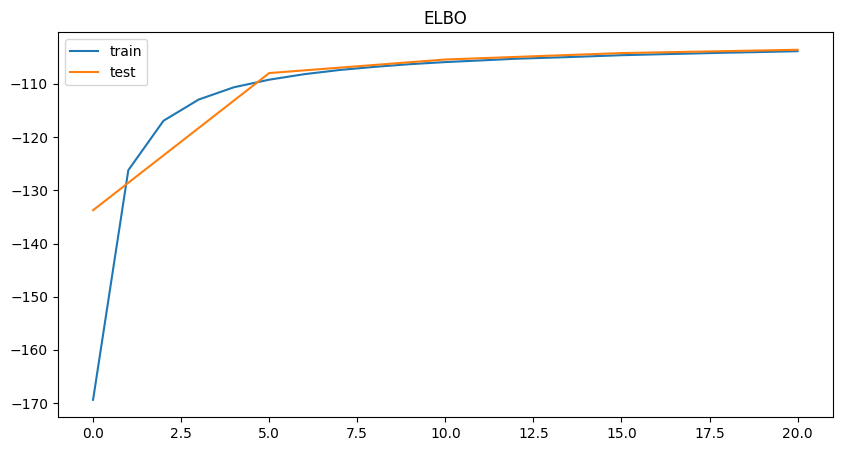

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_elbo, label='train')
plt.plot(range(0, len(train_elbo), TEST_FREQUENCY), test_elbo, label='test')
plt.title('ELBO')
plt.legend()
#plt.yscale('symlog')
plt.show()

And now we train it again but with sampling latent variable 5 times and averaging the LL.

In [ ]:
torch.manual_seed(42)

N_SAMPLES = 5
NUM_EPOCHS = 21
TEST_FREQUENCY = 5

vae = VAE_torch().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

prior = torch.distributions.Normal(torch.tensor(0.).to(device),
                                   torch.tensor(1.).to(device))

train_elbo_samples = []
test_elbo_samples = []
# training loop
for epoch in range(NUM_EPOCHS):
    elbo = train(vae, optimizer, train_loader, n_samples=N_SAMPLES)
    train_elbo_samples.append(-elbo)
    print("[epoch %03d] average training loss: %.4f" % (epoch, train_elbo_samples[-1]))

    if epoch % TEST_FREQUENCY != 0:
        continue
        
    elbo = evaluate(vae, test_loader)
    test_elbo_samples.append(-elbo)
    print("----------> average test loss: %.4f" % (test_elbo_samples[-1]))

[epoch 000] average training loss: -165.8167
----------> average test loss: -128.6842
[epoch 001] average training loss: -121.7683
[epoch 002] average training loss: -113.4734
[epoch 003] average training loss: -110.0450
[epoch 004] average training loss: -108.1631
[epoch 005] average training loss: -106.9865
----------> average test loss: -105.8778
[epoch 006] average training loss: -106.1350
[epoch 007] average training loss: -105.5305
[epoch 008] average training loss: -105.0445
[epoch 009] average training loss: -104.6479
[epoch 010] average training loss: -104.3076
----------> average test loss: -104.0322
[epoch 011] average training loss: -104.0378
[epoch 012] average training loss: -103.8018
[epoch 013] average training loss: -103.5743
[epoch 014] average training loss: -103.3741
[epoch 015] average training loss: -103.1930
----------> average test loss: -103.0983
[epoch 016] average training loss: -103.0374
[epoch 017] average training loss: -102.8814
[epoch 018] average traini

Let's compare the ELBO histories:

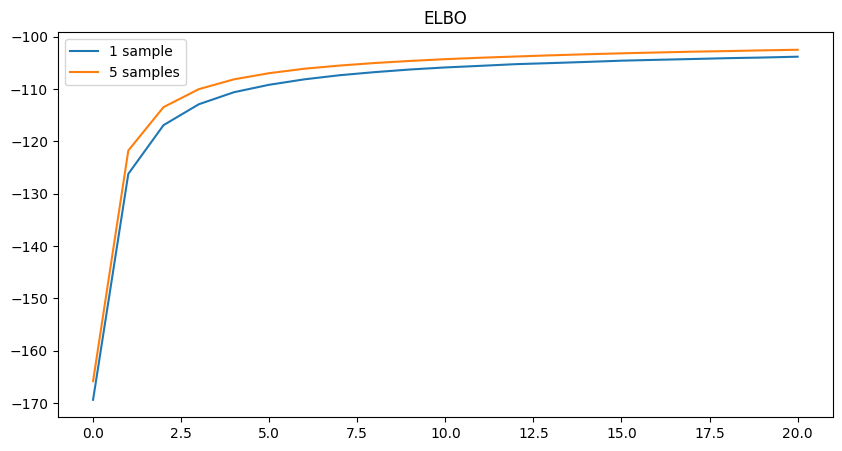

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_elbo, label='1 sample')
plt.plot(train_elbo_samples, label='5 samples')
plt.title('ELBO')
plt.legend()
#plt.yscale('symlog')
plt.show()

Since our gradients are less noisy the ELBO optimizes faster and in more stable way. But as wee see the diferrence is decreasing.

Check our VAE with random samples $z\sim \mathcal N(0,I)$

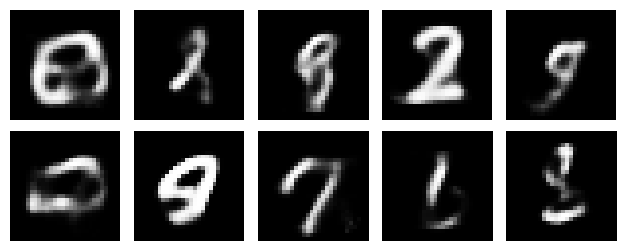

In [ ]:
torch.manual_seed(0)
z = torch.distributions.Normal(torch.zeros(50), torch.ones(50)).sample([10]).to(device)
x_mu = vae.decoder(z).view(-1, 28, 28).cpu().detach().numpy()

N, M = 2, 5
fig, ax = plt.subplots(N, M, figsize=(8, 3), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0.1)
for i in range(N):
    for j in range(M):
        ax[i][j].imshow(x_mu[i*M+j], cmap='gray')
        ax[i][j].axis('off')

plt.show()

Looks good. Don't forget that we choose very simple architecture.

### Pyro time

Now, we will try reimplement our VAE with pyro package. <br>
After that we will compare PyTorch and Pyro impementations.

Firstly, we already have architectures for encoder $q(z|x)$ and decoder $p(x|z)$. So, we have no need to rewrite it.<br>
Since we work with Pyro, we should define the model structure and declare all random variables.

In [ ]:
# define the model p(x|z)p(z) = p(x,z)
def model(self, x):
    # register PyTorch module `decoder` with Pyro
    pyro.module("decoder", self.decoder)
    with pyro.plate("data", x.shape[0]):
        # setup hyperparameters for prior p(z)
        z_mu = torch.zeros((x.shape[0], self.z_dim))
        z_sigma = torch.ones((x.shape[0], self.z_dim))
        # sample from prior (value will be sampled by guide when computing the ELBO)
        z = pyro.sample("latent", dist.Normal(z_mu, z_sigma).to_event(1))
        # decode the latent code z
        img_mu = self.decoder(z)
        # score against actual images
        pyro.sample("obs", dist.Bernoulli(img_mu).to_event(1), obs=x.reshape(-1, 784))

Additionaly, we should define the guide function to describe our posterior.

In [ ]:
# define the guide (i.e. variational distribution) q(z|x)
def guide(self, x):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", x.shape[0]):
        # use the encoder to get the parameters used to define q(z|x)
        z_mu, z_sigma = self.encoder(x)
        # sample the latent code z
        pyro.sample("latent", dist.Normal(z_mu, z_sigma).to_event(1))

And now we can implement it as methods of our VAE.

In [ ]:
vae = VAE_torch()
vae.model = model
vae.guide = guide

From scratch our VAE has the following structure.

In [ ]:
class VAE_pyro(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_mu = torch.zeros((x.shape[0], self.z_dim)).to(device)
            z_sigma = torch.ones((x.shape[0], self.z_dim)).to(device)
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_mu, z_sigma).to_event(1))
            # decode the latent code z
            img_mu = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(img_mu).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_mu, z_sigma = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_mu, z_sigma).to_event(1))

    # define a helper function for reconstructing images
    def forward(self, x):
        # encode image x
        z_mu, z_sigma = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_mu, z_sigma).rsample()
        # decode the image (note we don't sample in image space)
        img_mu = self.decoder(z)
        img_mu = img_mu.view(-1, 28*28)
        return img_mu

The train and evaluation procedure has now following structure.<br>
Here we use pyro built-in SVI algorithm.

In [ ]:
def train(svi, train_loader):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        x = x.to(device)
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    total_epoch_loss_train = epoch_loss / len(train_loader.dataset)
    return total_epoch_loss_train


def evaluate(svi, test_loader):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        x = x.to(device)
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
        
    total_epoch_loss_test = test_loss / len(test_loader.dataset)
    return total_epoch_loss_test

And finally, we train our VAE.

In [ ]:
NUM_EPOCHS = 21
TEST_FREQUENCY = 5

pyro.set_rng_seed(42)
torch.manual_seed(42)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE_pyro().to(device)

# setup the optimizer
adam_args = {"lr": 1e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo_pyro = []
test_elbo_pyro = []
# training loop
for epoch in range(NUM_EPOCHS):
    elbo = train(svi, train_loader)
    train_elbo_pyro.append(-elbo)
    print("[epoch %03d] average training loss: %.4f" % (epoch, train_elbo_pyro[-1]))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        elbo = evaluate(svi, test_loader)
        test_elbo_pyro.append(-elbo)
        print("----------> average test loss: %.4f" % (test_elbo_pyro[-1]))

[epoch 000] average training loss: -171.4386
----------> average test loss: -136.7623
[epoch 001] average training loss: -128.5200
[epoch 002] average training loss: -118.3807
[epoch 003] average training loss: -113.7820
[epoch 004] average training loss: -111.1939
[epoch 005] average training loss: -109.5944
----------> average test loss: -108.3099
[epoch 006] average training loss: -108.4668
[epoch 007] average training loss: -107.6804
[epoch 008] average training loss: -107.0811
[epoch 009] average training loss: -106.6235
[epoch 010] average training loss: -106.2441
----------> average test loss: -105.6705
[epoch 011] average training loss: -105.9210
[epoch 012] average training loss: -105.6012
[epoch 013] average training loss: -105.3782
[epoch 014] average training loss: -105.1604
[epoch 015] average training loss: -104.9609
----------> average test loss: -104.6191
[epoch 016] average training loss: -104.8082
[epoch 017] average training loss: -104.6270
[epoch 018] average traini

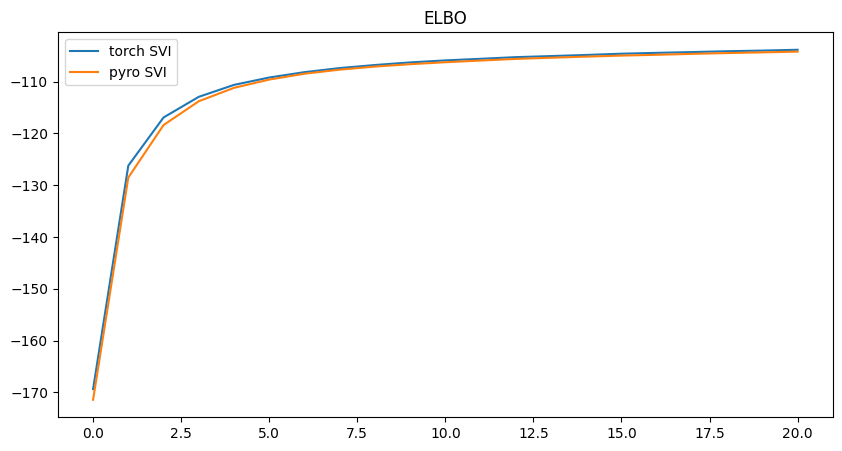

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_elbo, label='torch SVI')
plt.plot(train_elbo_pyro, label='pyro SVI')
plt.title('ELBO')
plt.legend()
#plt.yscale('symlog')
plt.show()

No we compare PyTorch and Pyro advantages:

PyTorch:
+ No need to declare all randomness with model and guide structure.
- We should care about ELBO implementation.

Pyro:
- We have to declare all randomness with model and guide structure.
+ The optimization is built-in.

Also, with Pyro it is much easier to do following research: CI, prediction averaging, etc.

### EOF